In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

In [3]:
import tensorflow as tf
import numpy as np
import warnings

from tflearn.layers.core import fully_connected, dropout
from tflearn.layers.conv import conv_1d, avg_pool_1d, highway_conv_1d
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.core import fully_connected

from tf_lab.fundamentals.layers import conv_1d_tranpose
from tf_lab.fundamentals.utils import expand_scope_by_name, replicate_parameter_for_all_layers

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
dropout = tf.nn.dropout
# from tflearn.layers.core import fully_connected, dropout


In [6]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
# experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'
loss = 'chamfer'
n_pc_points = 2048
random_seed = 42
# bneck_list = [128]
class_name = raw_input('Give me the class type: ').lower()

Give me the class type: chair


In [7]:
syn_id = snc_category_to_synth_id()[class_name]
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1, n_pc_points=2048)

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [61]:
def adaptive_hierarchical_encoder(in_signal, n_filters=[64, 128, 256, 1024], filter_sizes=[1], strides=[1],
                                        b_norm=True, spn=False, non_linearity=tf.nn.relu, regularizer=None, weight_decay=0.001,
                                        symmetry=tf.reduce_max, dropout_prob=None, pool=avg_pool_1d, pool_sizes=None, scope=None,
                                        reuse=False, padding='same', verbose=False, closing=None, conv_op=conv_1d):
    '''An Encoder (recognition network), which maps inputs onto a latent space.
    '''

    if verbose:
        print 'Building Encoder'

    n_pc_points = int(in_signal.shape[1])
#     batch_size = tf.shape(in_signal)[0]
    batch_size = 50
    
    print batch_size
        
    n_layers = len(n_filters)
    filter_sizes = replicate_parameter_for_all_layers(filter_sizes, n_layers)
    strides = replicate_parameter_for_all_layers(strides, n_layers)
#     dropout_prob = replicate_parameter_for_all_layers(dropout_prob, n_layers)

    if n_layers < 2:
        raise ValueError('More than 1 layers are expected.')

    if spn:
        transformer = pcloud_spn(in_signal)
        in_signal = tf.batch_matmul(in_signal, transformer)
        print 'Spatial transformer was activated.'
    
    covariances = []
    for i in xrange(n_layers):
        if i == 0:
            layer = in_signal

        name = 'encoder_conv_layer_' + str(i)
        scope_i = expand_scope_by_name(scope, name)
        layer = conv_op(layer, nb_filter=n_filters[i], filter_size=filter_sizes[i], strides=strides[i], regularizer=regularizer,
                        weight_decay=weight_decay, name=name, reuse=reuse, scope=scope_i, padding=padding)
        
        if verbose:
            print name, 'conv params = ', np.prod(layer.W.get_shape().as_list()) + np.prod(layer.b.get_shape().as_list()),

        if b_norm:
            name += '_bnorm'
            scope_i = expand_scope_by_name(scope, name)
            layer = batch_normalization(layer, name=name, reuse=reuse, scope=scope_i)
            if verbose:
                print 'bnorm params = ', np.prod(layer.beta.get_shape().as_list()) + np.prod(layer.gamma.get_shape().as_list())

        if non_linearity is not None:
            layer = non_linearity(layer)

        if pool is not None and pool_sizes is not None:
            if pool_sizes[i] is not None:
                layer = pool(layer, kernel_size=pool_sizes[i])

        cov_layer_i = tf.matmul(layer, layer, transpose_b=True)
        cov_layer_i = tf.nn.softmax(cov_layer_i, dim=1, name="soft-max-coupling")
#         cov_layer_i = tf.expand_dims(cov_layer_i, 0)
#         cov_layer_i = tf.tile(cov_layer_i, [batch_size, 1, 1])
        layer = tf.matmul(cov_layer_i, layer)
#         print layer 
        
    
        if dropout_prob is not None and dropout_prob[i] != 0:
            layer = dropout(layer, 1.0 - dropout_prob[i])

        if verbose:
            print layer
            print 'output size:', np.prod(layer.get_shape().as_list()[1:]), '\n'

    if symmetry is not None:
        layer = symmetry(layer, axis=1)
        if verbose:
            print layer

    if closing is not None:
        layer = closing(layer)
        print layer
    
    return layer

In [66]:
conv_op = conv_1d
n_filters = [32, 32, 64]
filter_sizes = [1]
strides = [1]
bneck = 128
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck)

enc_args = {'n_filters': n_filters}
# in_signal = tf.placeholder(tf.float32, shape=(None, 2048, 3))

In [38]:
# Try 32-32-32-32: to also be de-corelated

In [67]:
train_params = default_train_params()
# experiment_id = '_'.join(['ae', class_name, experiment_tag, str(n_pc_points), 'pts', str(bneck), 'bneck', loss])
experiment_id = '1'
train_dir = osp.join(top_data_dir, 'OUT/temp/', experiment_id)
create_dir(train_dir)

reset_tf_graph()

conf = Conf(n_input = [n_pc_points, 3],
            loss = loss,
            training_epochs = 500,
            batch_size = train_params['batch_size'],
            denoising = False,
            learning_rate = 0.0005,
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = train_params['saver_step'],
            z_rotate = False,
            encoder = adaptive_hierarchical_encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
print conf
conf.experiment_name = 'experiment_' + str(experiment_id)
conf.held_out_step = 5
conf.save(osp.join(train_dir, 'configuration'))
ae = PointNetAutoEncoder(conf.experiment_name, conf)

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'b_norm_finish': False, 'verbose': True, 'b_norm': False, 'layer_sizes': [256, 256, 6144]}
                       encoder: adaptive_hierarchical_encoder
                  encoder_args: {'n_filters': [32, 32, 64]}
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/optas/DATA/OUT/temp/1
               training_epochs: 500
                      z_rotate: False

50
Building Decoder
dec

In [68]:
ae.trainable_parameters()

1664992

In [ ]:
buf_size = 1 # flush each line
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(in_data['train'], conf, log_file=fout, held_out_data=in_data['val'])
fout.close()

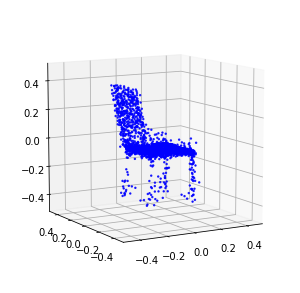

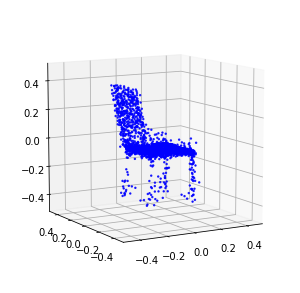

In [64]:
# Point_Cloud(ae.reconstruct(in_data['test'].next_batch(1)[0])[0][0]).plot()

In [ ]:
# g = tf.get_default_graph()
# g.get_all_collection_keys()
# v = g.get_collection('trainable_variables')[0]

In [41]:
lala = ae.sess.run(tf.nn.softmax(v, dim=1), feed_dict={ae.x:in_data['train'].next_batch(50)[0]})
np.sum(lala, axis=1)

In [42]:
in_signal = tf.placeholder(tf.float32, [None, 2048, 3])
out = adaptive_hierarchical_encoder(in_signal, n_filters=n_filters, filter_sizes=[1], strides=[1],
                              b_norm=True, spn=False, non_linearity=tf.nn.relu, regularizer=None, weight_decay=0.001,
                              symmetry=tf.reduce_max, dropout_prob=None, pool=avg_pool_1d, pool_sizes=None, scope=None,
                              reuse=False, padding='same', verbose=False, closing=None, conv_op=conv_1d)

50


In [43]:
out

<tf.Tensor 'Max:0' shape=(?, 128) dtype=float32>